In [1]:
import numpy as np
import numpy.linalg as mat
import scipy as sp
import scipy.linalg as smat
import cvxpy as cp

import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import peartree as pt #turns GTFS feed into a graph
import folium

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

from matplotlib.patches import FancyArrow
from itertools import product 
from random import sample
from shapely.geometry import Polygon, Point


In [2]:
%load_ext autoreload
%autoreload 2

from continuous_type_sample_dists_full import * 

# PROBLEM CODE 

# LOADING DATA

### LOAD GTFS FEED...

### LOAD GRAPHS...

In [3]:

start_time = time.time();
center_point = (35.0458,-85.3094)


# Loading GTFS feed
feed = pt.get_representative_feed('carta_gtfs.zip') #loading gtfs from chattanooga
start = 8*60*60; end = 9*60*60;
%time graph_bus = pt.load_feed_as_graph(feed,start,end)
bus_boundary = gpd.GeoSeries([Point(n['x'],n['y']) for i,n in graph_bus.nodes(data=True)]).unary_union.convex_hull

# if 'bus' in GRAPHS.keys():        
#         %time GRAPHS['types[i]] = ox.graph_from_polygon(bus_boundary,network_type=types[i]) # 'drive')        
#     else: 
#         GRAPHS[types[i]] = ox.graph_from_point(center_point, dist=4000,network_type=types[i])

types = ['bike',"walk", "drive"] #, "drive_service", "walk"]; #types = ["all_private", "all", "bike", "drive", "drive_service", "walk"]
opts = ['drive','share','walk_bus','share_bus']


connection_types = ['bike','drive','walk']; #'share','walk'];    
od_types = ['transit','drive','walk','ondemand'];
connect_types = ['bike','drive','walk'];


loop_types = ['walk','drive'] #,'walk_bus','sharegraph']
opt_graphs = [['walk'],['drive']];#,['walk','bus','walk'],['drive','bus','drive']];
opt_chains = dict(zip(loop_types,opt_graphs));

dijkstra_from_origin = ['walk','drive'];
dijkstra_from_dest = ['walk','drive'];
raptor_from_origin = ['bus_gtfs'];

graph_types = ['bus_graph','bus_graph_wt','bus_gtfs','walk','bike','drive','share']

LENGTHS = {}; PATHS = {};
for i,typ in enumerate(graph_types):
    LENGTHS[typ] = {'orig':{},'dest':{}};
    PATHS[typ] = {'orig':{},'dest':{}}


CPU times: user 2.49 s, sys: 18.1 ms, total: 2.51 s
Wall time: 2.52 s


In [4]:


radius = 2000;

start_time = time.time()

# Loading different graphs  ox.   osmnx
center_point = (35.0458,-85.3094) #(lat, lon)
GRAPHS = {};
GRAPHS['bus_graph'] = graph_bus.copy();
GRAPHS['bus_graph_wt'] = graph_bus.copy();
GRAPHS['bus_gtfs'] = graph_bus.copy();
GRAPHS['walk'] = ox.graph_from_point(center_point, dist=radius,network_type='walk')
GRAPHS['transit'] = ox.graph_from_point(center_point, dist=radius,network_type='bike')
GRAPHS['drive'] = ox.graph_from_point(center_point, dist=radius,network_type='drive')
# GRAPHS['drive1'] = ox.graph_from_point(center_point, dist=radius,network_type='drive')
# GRAPHS['drive2'] = ox.graph_from_point(center_point, dist=radius,network_type='drive')
# GRAPHS['drive3'] = ox.graph_from_point(center_point, dist=radius,network_type='drive')
GRAPHS['ondemand'] = ox.graph_from_point(center_point, dist=radius,network_type='drive')
# GRAPHS['drive_small'] = ox.graph_from_point(center_point, dist=1000,network_type='drive')

# for i in range(len(types)):
#     if 'bus' in GRAPHS.keys():        
#         %time GRAPHS[types[i]] = ox.graph_from_polygon(bus_boundary,network_type=types[i]) # 'drive')        
#     else: `
        
RGRAPHS = {};
for i,typ in enumerate(GRAPHS):
    RGRAPHS[typ] = GRAPHS[typ].reverse()  
end_time = time.time();
print('Time to import maps: ',end_time-start_time)




Time to import maps:  8.458130836486816


In [5]:
graph_bus_wt = graph_bus.copy();
bus_nodes = list(graph_bus_wt.nodes);
print('Original num of edges: ', len(graph_bus_wt.edges))
for i in range(len(bus_nodes)):
    for j in range(len(bus_nodes)):
        node1 = bus_nodes[i]
        node2 = bus_nodes[j]
        x1 = graph_bus_wt.nodes[node1]['x']
        y1 = graph_bus_wt.nodes[node1]['y']        
        x2 = graph_bus_wt.nodes[node2]['x']
        y2 = graph_bus_wt.nodes[node2]['y']
        diff = np.array([x1-x2,y1-y2]);
        dist = mat.norm(diff)
        if (dist==0):
            graph_bus_wt.add_edge(node1,node2)
            graph_bus_wt.add_edge(node2,node1)
        #GRAPHS['bus'].add_edge(node1,node2) #['transfer'+str(i)+str(j)] = (node1,node2,0);
print('Final num of edges: ', len(graph_bus_wt.edges))
GRAPHS['bus_graph_wt'] = graph_bus_wt
GRAPHS['transit']= graph_bus_wt.copy()

Original num of edges:  840
Final num of edges:  2454


In [6]:
radius2 = 0.0000125*radius;
nodes_to_keep = [];
old_graph = graph_bus_wt.copy();
for e,edge in enumerate(old_graph.edges):
    node1,node2,_ = edge;
    if not((node2,node1,0) in old_graph.edges):
        old_graph.add_edge(node2,node1)
for i,node in enumerate(old_graph.nodes):
    NODE = old_graph.nodes[node];
    lon = NODE['x']; lat = NODE['y'];
    centerx = center_point[1]; centery = center_point[0];
    dist = np.sqrt((centerx-lon)*(centerx-lon) + (centery-lat)*(centery-lat))
    if dist < radius2:
        nodes_to_keep.append(node);
#         print(center_point)
#         print(lat)
graph_new = old_graph.subgraph(nodes_to_keep)
# graph_new = nx.compose(GRAPHS['drive'],graph_new)
components = list(nx.strongly_connected_components(graph_new))
# print(len(list(asdf)))
large_components = [];
for i,component in enumerate(components):
    #if len(component)>1:
    large_components.append(component)
        
#graph_new = nx.compose(GRAPHS['drive'],graph_new)        
sub_graphs = [];
sampled_nodes = [];
for i,component in enumerate(large_components):
    sub_graphs.append(graph_new.subgraph(component))
    sampled_nodes.append(sample(sub_graphs[-1].nodes,1)[0])
graph_new = nx.compose_all(sub_graphs);

# for i,node1 in enumerate(sampled_nodes):
#     for j,node2 in enumerate(sampled_nodes):
#         if j>i:
#             graph_new.add_edge(node1,node2)
#             graph_new.add_edge(node2,node1)
for i,node1 in enumerate(sampled_nodes):
    if i< len(sampled_nodes)-1:
        node2 = sampled_nodes[i+1]
        graph_new.add_edge(node1,node2)
        graph_new.add_edge(node2,node1)            
GRAPHS['transit'] = graph_new.copy()


In [7]:
start_time = time.time()
sample_graph = GRAPHS['drive'];

# source
# num_samples = 20;
# NODE_LIST = sample(list(sample_graph.nodes()), num_samples)
num_sources = 100;
num_targets = num_sources;
num_deliveries = 5;
num_deliveries2 = 5;
# print(sample(list(sample_graph.nodes()),10))
source_nodes = sample(list(sample_graph.nodes()), num_sources)
target_nodes = sample(list(sample_graph.nodes()), num_targets)
delivery1_nodes = sample(list(sample_graph.nodes()), num_deliveries)
delivery2_nodes = sample(list(sample_graph.nodes()), num_deliveries)

sample_graph = GRAPHS['drive'];

ORIG_LOC = [];
for i,node in enumerate(source_nodes):
    x = sample_graph.nodes[node]['x']
    y = sample_graph.nodes[node]['y']
    ORIG_LOC.append((x,y));
    
DEST_LOC = [];
for i,node in enumerate(target_nodes):
    x = sample_graph.nodes[node]['x']
    y = sample_graph.nodes[node]['y']
    DEST_LOC.append((x,y));
    #DEST_LOC.append((center_point[0],center_point[1]))

DELIVERY1_LOC = [];
for i,node in enumerate(delivery1_nodes):
    x = sample_graph.nodes[node]['x']
    y = sample_graph.nodes[node]['y']
    DELIVERY1_LOC.append((x,y));

DELIVERY2_LOC = [];
for i,node in enumerate(delivery2_nodes):
    x = sample_graph.nodes[node]['x']
    y = sample_graph.nodes[node]['y']
    DELIVERY2_LOC.append((x,y));
        


bus_graph = GRAPHS['bus_graph_wt'];
# transit_start_nodes = sample(list(bus_graph.nodes()), num_sources)
# transit_end_nodes = sample(list(bus_graph.nodes()), num_targets)
delivery_transit_nodes = sample(list(bus_graph.nodes()), num_deliveries2)
    
# transit_start_nodes = []; #sample(list(bus_graph.nodes()), num_sources)
# transit_end_nodes = []; #sample(list(bus_graph.nodes()), num_targets)    
# walk_transit_init_nodes = [];
# walk_transit_final_nodes = [];
# for i,_ in enumerate(source_nodes):
#     loc = ORIG_LOC[i];
#     node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);    
#     transit_start_nodes.append(node);
#     x = GRAPHS['transit'].nodes[node]['x']
#     y = GRAPHS['transit'].nodes[node]['y']
#     node = ox.distance.nearest_nodes(GRAPHS['walk'],x,y);
#     walk_transit_init_nodes.append(node);    

# for i,_ in enumerate(target_nodes):
#     loc = DEST_LOC[i];
#     node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
#     transit_end_nodes.append(node);
#     x = GRAPHS['transit'].nodes[node]['x']
#     y = GRAPHS['transit'].nodes[node]['y']
#     node = ox.distance.nearest_nodes(GRAPHS['walk'],x,y);
#     walk_transit_final_nodes.append(node);    
    
# TRANSIT_START_LOC = []; 
# for i,node in enumerate(transit_start_nodes):
#     x = GRAPHS['transit'].nodes[node]['x']
#     y = GRAPHS['transit'].nodes[node]['y']
#     TRANSIT_START_LOC.append((x,y));
#     #DEST_LOC.append((center_point[0],center_point[1]))

# TRANSIT_END_LOC = [];
# for i,node in enumerate(transit_end_nodes):
#     x = GRAPHS['transit'].nodes[node]['x']
#     y = GRAPHS['transit'].nodes[node]['y']
#     TRANSIT_END_LOC.append((x,y));
#     #DEST_LOC.append((center_point[0],center_point[1]))
# WALK_TRANSIT_INIT_LOC = [];
# for i,node in enumerate(walk_transit_init_nodes):
#     x = GRAPHS['walk'].nodes[node]['x']
#     y = GRAPHS['walk'].nodes[node]['y']
#     WALK_TRANSIT_INIT_LOC.append((x,y));

# WALK_TRANSIT_FINAL_LOC = [];
# for i,node in enumerate(walk_transit_final_nodes):
#     x = GRAPHS['walk'].nodes[node]['x']
#     y = GRAPHS['walk'].nodes[node]['y']
#     WALK_TRANSIT_FINAL_LOC.append((x,y));
    
################################################################
################################################################    
        
# DELIVERY_TRANSIT_LOC = [];
# for i,node in enumerate(delivery_transit_nodes):
#     x = GRAPHS['transit'].nodes[node]['x']
#     y = GRAPHS['transit'].nodes[node]['y']
#     DELIVERY_TRANSIT_LOC.append((x,y));    
    
    
# DELIVERY_LOC = [];
# for i,node in enumerate(delivery_nodes):
#     x = sample_graph.nodes[node]['x']
#     y = sample_graph.nodes[node]['y']
#     DELIVERY_LOC.append((x,y));
    
    
# delivery2_nodes = sample(list(sample_graph.nodes()), num_deliveries2)    
# DELIVERY2_LOC = [];
# for i,node in enumerate(delivery_nodes):
#     x = sample_graph.nodes[node]['x']
#     y = sample_graph.nodes[node]['y']
#     DELIVERY2_LOC.append((x,y));


    

indstoremove = [];
for i in range(len(ORIG_LOC)):
#     for j in range(len(DEST_LOC)):
#         #add_OD_pair = True;
    try:
        orig = ox.distance.nearest_nodes(sample_graph, ORIG_LOC[i][0], ORIG_LOC[i][1]);
        dest = ox.distance.nearest_nodes(sample_graph, DEST_LOC[i][0], DEST_LOC[i][1]);
        path = nx.shortest_path(sample_graph, source=orig, target=dest, weight=None)
    except:
        if not(i in indstoremove):
            indstoremove.append(i)                
                
# print(indstoremove)
# for i in indstoremove[::-1]:
#     print('Origin ',i,' deleted...')
#     ORIG_LOC.pop(i)
#     DEST_LOC.pop(i)    
    
    

end_time = time.time();
print('time to setup origins & dests: ',end_time - start_time)


delivery1_node_lists = {}
delivery2_node_lists = {}

delivery1_node_lists['source'] = delivery1_nodes;
delivery1_node_lists['transit'] = [];
delivery2_node_lists['source'] = delivery2_nodes;
    

time to setup origins & dests:  0.7244350910186768


In [8]:
# #G2 = max(nx.strongly_connected_components_subgraphs(GRAPHS['transit']), key=len)
# center_node = ox.distance.nearest_nodes(GRAPHS['transit'], center_point[0],center_point[1]);
# important_nodes1 = transit_start_nodes + transit_end_nodes + delivery_transit_nodes;
# important_nodes2 = transit_start_nodes + transit_end_nodes + delivery_transit_nodes;
# graph = GRAPHS['transit']
# print(len(GRAPHS['transit'].nodes))
# print('original node number: ', len(important_nodes2))
# for i,node in enumerate(important_nodes1):
#     try: 
#         path = nx.shortest_path(graph, source=center_node, target=node, weight=None);
#         for j,nn in enumerate(path):
#             if not(nn in important_nodes2):
#                 important_nodes2.append(nn)
#     except:
#         print('no path found...')
# print('final node number: ', len(important_nodes2)) 
# GRAPHS['transit'] = GRAPHS['transit'].subgraph(important_nodes2)
# print(GRAPHS['transit'])


In [9]:
# start_time = time.time();
# ORIGS = {}; DESTS = {}; ODS = {};
# for k,typ in enumerate(od_types): #range(len(orig_types)):
#     graph = GRAPHS[typ];
#     ORIGS[typ] = [];
#     DESTS[typ] = [];
    
#     for i in range(len(ORIG_LOC)):
#         ORIGS[typ].append(ox.distance.nearest_nodes(graph, ORIG_LOC[i][0], ORIG_LOC[i][1]));
#         #print(ORIG[-1])
#     for i in range(len(DEST_LOC)):
#         DESTS[typ].append(ox.distance.nearest_nodes(graph, DEST_LOC[i][0], DEST_LOC[i][1]));
#         #print(DEST[-1])
#     ODS[typ] = {};        
#     for i in range(len(ORIG_LOC)):
#         for j in range(len(DEST_LOC)):
#             ODS[typ][(i,j)] = [ORIGS[typ][i],DESTS[typ][j]]
# end_time = time.time()
# print('time to compute origins and destinations: ',end_time-start_time)

In [10]:
NODES = {};
NODESDF = pd.DataFrame({'drive':[],
                              'walk':[],
                              'transit':[],
                              'ondemand':[]},
                              index=[])

print('starting delivery1 sources...')
for i,node in enumerate(delivery1_node_lists['source']):
    drive_node = node #['drive']
    if np.mod(i,200)==0: print(i)
    node_index = 'node'+str(len(NODESDF.index));
    walk_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['walk']);
    transit_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['transit']);
    ondemand_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['ondemand']);    
    new_nodes = pd.DataFrame({'drive':[drive_node],'walk':[walk_node],
                              'transit':[transit_node],'ondemand':[ondemand_node]},
                              index=[node_index])
    NODESDF = NODESDF.append(new_nodes);    
    
print('starting delivery2 sources...')
for i,node in enumerate(delivery2_node_lists['source']):
    drive_node = node #['drive']
    if np.mod(i,200)==0: print(i)
    node_index = 'node'+str(len(NODESDF.index));
    walk_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['walk']);
    transit_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['transit']);
    ondemand_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['ondemand']);    
    new_nodes = pd.DataFrame({'drive':[drive_node],'walk':[walk_node],
                              'transit':[transit_node],'ondemand':[ondemand_node]},
                              index=[node_index])
    NODESDF = NODESDF.append(new_nodes);    

print('starting source nodes...')
for i,node in enumerate(source_nodes):
    drive_node = node; #node['drive']
    if np.mod(i,200)==0: print(i)
    node_index = 'node'+str(len(NODESDF.index));
    walk_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['walk']);
    transit_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['transit']);
    ondemand_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['ondemand']);    
    new_nodes = pd.DataFrame({'drive':[drive_node],'walk':[walk_node],
                              'transit':[transit_node],'ondemand':[ondemand_node]},
                              index=[node_index])
    NODESDF = NODESDF.append(new_nodes);    
    
print('starting target nodes...')
for i,node in enumerate(target_nodes):
    drive_node = node; #node['drive']
    if np.mod(i,200)==0: print(i)
    node_index = 'node'+str(len(NODESDF.index));
    walk_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['walk']);
    transit_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['transit']);
    ondemand_node = find_close_node(drive_node,GRAPHS['drive'],GRAPHS['ondemand']);    
    new_nodes = pd.DataFrame({'drive':[drive_node],'walk':[walk_node],
                              'transit':[transit_node],'ondemand':[ondemand_node]},
                              index=[node_index])
    NODESDF = NODESDF.append(new_nodes);    

print('starting transit nodes...')
for i,node in enumerate(list(GRAPHS['transit'].nodes())):
    if np.mod(i,200)==0: print(i)
    node_index = 'node'+str(len(NODESDF.index));
    transit_node = node;
    walk_node = find_close_node(node,GRAPHS['transit'],GRAPHS['walk']);
    drive_node = find_close_node(node,GRAPHS['transit'],GRAPHS['drive']);
    ondemand_node = find_close_node(node,GRAPHS['transit'],GRAPHS['ondemand']);    
    new_nodes = pd.DataFrame({'drive':[drive_node],'walk':[walk_node],
                              'transit':[transit_node],'ondemand':[ondemand_node]},
                              index=[node_index])
    NODESDF = NODESDF.append(new_nodes);
    

    # NODES[node_walk] = {'transit':node}; #,'walk':node_walk,'drive':node_drive,'ondemand':node_ondemand}


starting delivery1 sources...
0
starting delivery2 sources...
0
starting source nodes...
0
starting target nodes...
0
starting transit nodes...
0


In [11]:
NODES['all'] = NODESDF.copy();
updateNodesDF(NODES);

# NODES['transit'] = NODESDF.copy(); #.set_index('transit')[find_node])
# NODES['drive'] = NODESDF.copy();
# NODES['walk'] = NODESDF.copy();
# NODES['ondemand'] = NODESDF.copy();

# NODES['transit']['transit2'] = NODES['transit']['transit'].copy(); 
# NODES['drive']['drive2'] = NODES['drive']['drive'].copy();
# NODES['walk']['walk2'] = NODES['walk']['walk'].copy();
# NODES['ondemand']['ondemand2'] = NODES['ondemand']['ondemand'].copy(); 

# NODES['transit'] = NODES['transit'].set_index('transit2')
# NODES['drive'] = NODES['drive'].set_index('drive2')
# NODES['walk'] = NODES['walk'].set_index('walk2')
# NODES['ondemand'] = NODES['ondemand'].set_index('ondemand2')

# NODES['transit'] = NODES['transit'].drop_duplicates(keep='first');
# NODES['drive'] = NODES['drive'].drop_duplicates(keep='first');
# NODES['walk'] = NODES['walk'].drop_duplicates(keep='first');
# NODES['ondemand'] = NODES['ondemand'].drop_duplicates(keep='first');
# # NODES['drive'] = NODES['drive'].set_index('drive2')
# # NODES['walk'] = NODES['walk'].set_index('walk2')
# # NODES['ondemand'] = NODES['ondemand'].set_index('ondemand2')

# # drop_duplicates(keep='first')

In [12]:
print(NODES['ondemand'])

                     drive          walk     transit      ondemand
ondemand2                                                         
6.512767e+08  6.512767e+08  6.512767e+08   4EVER_425  6.512767e+08
9.466524e+08  9.466524e+08  9.466524e+08   4EVER_762  9.466524e+08
1.845471e+09  1.845471e+09  1.845471e+09   4EVER_755  1.845471e+09
8.100752e+08  8.100752e+08  8.100752e+08   4EVER_740  8.100752e+08
4.502891e+08  4.502891e+08  4.502891e+08    4EVER_24  4.502891e+08
...                    ...           ...         ...           ...
6.512767e+08  6.512767e+08  6.512767e+08   4EVER_426  6.512767e+08
2.026337e+08  2.026337e+08  8.902916e+09   4EVER_413  2.026337e+08
2.026486e+08  2.026486e+08  6.833105e+09   4EVER_995  2.026486e+08
2.027009e+08  2.027009e+08  2.027009e+08  4EVER_1089  2.027009e+08
2.026960e+08  2.026960e+08  2.026960e+08   4EVER_817  2.026960e+08

[293 rows x 4 columns]


In [ ]:
find_node = list(GRAPHS['transit'].nodes())[0]
start_time = time.time();
xx = GRAPHS['transit'][find_node]
end_time = time.time();
print('time to find in graph: ', end_time-start_time)

find_node = list(GRAPHS['transit'].nodes())[0]
start_time = time.time();
xx = NODES['transit']['drive'][find_node]
end_time = time.time();
print('time to index in df: ', end_time-start_time)

find_node = list(GRAPHS['transit'].nodes())[0]
start_time = time.time();
loc = np.where(NODESDF == find_node)
end_time = time.time();
print('time to find in df: ', end_time-start_time)

In [ ]:
zmodes = ['drive','transit','drive'];
znodes = [[delivery1_node_lists['source'][0]],
          [list(GRAPHS['transit'].nodes())[0]],
          [list(GRAPHS['transit'].nodes())[-1]],
          [delivery1_node_lists['source'][-1]]];
ztypes = ['drive','transit','transit','drive']

ztrip = makeTrip(zmodes,znodes,ztypes,NODES);#deliveries = []):

zmodes2 = ['drive','transit','drive'];
znodes2 = [{'nodes':[delivery1_node_lists['source'][0]],'type':'drive'},
           {'nodes':[list(GRAPHS['transit'].nodes())[0]],'type':'transit'},
           {'nodes':[list(GRAPHS['transit'].nodes())[-1]],'type':'transit'},
           {'nodes':[delivery1_node_lists['source'][-1]],'type':'drive'}];
ztypes2 = ['drive','transit','transit','drive']

ztrip2 = makeTrip2(zmodes2,znodes2,NODES);#deliveries = []):



In [ ]:
print(delivery1_node_lists['source'][0])
print(NODES['drive']['transit'][NODES['drive'].index[0]])
print(ztrip)
print(ztrip2['structure'])
calcTrip(ztrip,PEOPLE['person0'],NODES,GRAPHS,WORLD)
print(NODES['drive'].index.drop_duplicated())

### BUS STOP NODES

In [ ]:
print(delivery1_node_lists['source']);
print(delivery2_node_lists['source']);

print(node_lists['source'])
print(node_lists['target'])

In [13]:
# find the closest node in each network to bus stops... 
### COMPUTING BUS STOP NODES IN OTHER GRAPHS ####

if (recompute_close_nodes):
    BUS_STOP_NODES = {};
    BUS_STOP_NODES['bus'] = {}; 
    start_time = time.time()
    #BUS_STOP_NODES['drive'] = bus_stop_nodes(feed,GRAPHS['drive'])    
    BUS_STOP_NODES['drive'] = bus_stop_nodes_wgraph(GRAPHS['transit'],GRAPHS['drive'])        
    end_time = time.time()
    print('time to compute drive bus nodes...', end_time - start_time)
    print('')
    start_time = time.time()
    #BUS_STOP_NODES['ondemand'] = bus_stop_nodes(feed,GRAPHS['ondemand'])
    BUS_STOP_NODES['ondemand'] = bus_stop_nodes_wgraph(GRAPHS['transit'],GRAPHS['ondemand'])            

    end_time = time.time()
    print('time to compute ondemand bus nodes...', end_time - start_time)
    print('')    
    start_time = time.time()
    #BUS_STOP_NODES['walk'] = bus_stop_nodes(feed,GRAPHS['walk'])
    BUS_STOP_NODES['walk'] = bus_stop_nodes_wgraph(GRAPHS['transit'],GRAPHS['walk'])    
    end_time = time.time()
    print('time to compute walk bus nodes...', end_time - start_time)
    print('')    
    recompute_close_nodes = False;



time to compute drive bus nodes... 0.6060459613800049

time to compute ondemand bus nodes... 0.7042198181152344

time to compute walk bus nodes... 1.8383150100708008



In [14]:
# all_bus_stops = [];
    
# ORIG_CONNECTIONS = {'bike':{}, 'drive':{},'walk':{}};
# DEST_CONNECTIONS = {'bike':{}, 'drive':{},'walk':{}};

# if (recompute_connection_nodes):
#     for i,person in enumerate(PEOPLE):
#         PERSON = PEOPLE[person];
#         source = PERSON['sources']['walk_initial'];
#         temp = bus_connection_nodes(GRAPHS['walk'],source,BUS_STOP_NODES['walk']);
        
#         PERSON = PEOPLE[person];
#         target = PERSON['targets']['walk_final'];
#         temp = bus_connection_nodes(GRAPHS['walk'],source,BUS_STOP_NODES['walk']);
        

### FINDING ORIGINS/DESTS IN EACH NETWORKS

# START NEW ---------- 
# TYPE CODE - GRAPH PLOTS

In [15]:
import random

graph = ox.graph_from_point(center_point, dist=2000,network_type='drive')

# out = nx.strongly_connected_components(graph)
out = [c for c in sorted(nx.strongly_connected_components(graph), key=len, reverse=True)]
temp = out[0];
print('number nodes: ', len(temp))
graph = graph.subgraph(temp)
GRAPHS['drive_small'] = graph;
nodes = list(graph.nodes())
edges = list(graph.edges())
npickups = 100;
all_pickup_nodes = random.choices(nodes,k=npickups)
sink = random.choices(nodes,k=1)[0]
source = random.choices(nodes,k=1)[0]
ndelivery1 = 10;
ndelivery2 = 10; 
delivery1_nodes = random.choices(nodes,k=ndelivery1)
delivery2_nodes = random.choices(nodes,k=ndelivery2)
sink_loc = np.array([graph.nodes[sink]['x'],graph.nodes[sink]['y']])
source_loc = np.array([graph.nodes[source]['x'],graph.nodes[source]['y']])

ne = len(graph.edges)
mean = 500; stdev = 25;
Mlocs = np.random.normal(mean,stdev,npickups);


num_people = len(ORIG_LOC);
people_tags = [];
for i in range(len(ORIG_LOC)):
    tag = 'person' + str(i);
    people_tags.append('person'+str(i));    


# opts = ['drive','ondemand','walk+transit','ondemand+transit'];
opts = ['drive','ondemand',
        'walk+transit+walk',
        'ondemand+transit+walk',
        'walk+transit+ondemand',        
        'ondemand+transit+ondemand'];
orders = [['drive'],
          ['ondemand'],
          ['walk','transit','walk'],
          ['ondemand','transit','walk'],
          ['walk','transit','ondemand'],          
          ['ondemand','transit','ondemand']];
          
modes = ['drive','ondemand','walk','transit'];
graphs = ['drive','ondemand','walk','transit'];
factors = ['time','money','conven','switches'];
means = [mean,mean,mean,mean];
stdevs = [stdev,stdev,stdev,stdev];


print(modes)
STATS = {}
for m,mode in enumerate(modes):
    STATS[mode] = {};
    STATS[mode]['mean'] = dict(zip(factors,means));
    STATS[mode]['stdev'] = dict(zip(factors,stdevs));

    
    
WORLD = {};
for m,mode in enumerate(modes):
    WORLD[mode] = {}
    WORLD[mode]['trips'] = {}
    WORLD[mode]['graph'] = graphs[m];
    WORLD[mode]['costs'] = {};
    WORLD[mode]['sources'] = [];
    WORLD[mode]['targets'] = [];
    WORLD[mode]['edge_masses'] = {};
    WORLD[mode]['edge_costs'] = {};
    WORLD[mode]['current_edge_masses'] = {};    
    WORLD[mode]['current_edge_costs'] = {};
    WORLD[mode]['people'] = people_tags.copy();
    WORLD[mode]['active_trips'] = [];
    for j,node in enumerate(nodes):
        WORLD[mode]['costs'][node] = dict(zip(factors,np.ones(len(factors))));
        
    GRAPH = GRAPHS[graphs[m]]
    edges = GRAPH.edges;
    for j,edge in enumerate(edges):
        WORLD[mode]['edge_masses'][edge] = [0];
        WORLD[mode]['edge_costs'][edge]=[1];
        WORLD[mode]['current_edge_masses'][edge]=0;
        WORLD[mode]['current_edge_costs'][edge]=1;        
        
WORLD['ondemand']['people'] = people_tags.copy();
 #people_tags.copy();
# WORLD['ondemand+transit']['people'] = people_tags.copy();
WORLD['ondemand']['trips'] = {};


maxMloc = np.max(Mlocs);
Mmass = np.ones(npickups);

number nodes:  706
['drive', 'ondemand', 'walk', 'transit']


## DELIVERY 

In [16]:
DELIVERY = {};
DELIVERY['direct'] = {};
DELIVERY['shuttle'] = {};
# DELIVERY['direct'] = {};
# DELIVERY['shuttle'] = {};
    
nopts = len(opts);
# people_tags = [];
delivery1_tags = [];
delivery2_tags = [];


delivery1_node_lists = {}
delivery2_node_lists = {}

delivery1_node_lists['source'] = delivery1_nodes;
delivery1_node_lists['transit'] = [];
delivery2_node_lists['source'] = delivery2_nodes;
delivery2_node_lists['transit'] = [];



delivery_nodes = [];
for i,loc in enumerate(DELIVERY1_LOC):
    tag = 'delivery1_' + str(i);
    delivery1_tags.append(tag);
    DELIVERY['direct'][tag] = {};
    DELIVERY['direct'][tag]['active_trips'] = [];
    DELIVERY['direct'][tag]['loc'] = loc; #DELIVERY1_LOC[i]
    DELIVERY['direct'][tag]['current_path'] = []    
    
    DELIVERY['direct'][tag]['nodes'] = {};
    node = ox.distance.nearest_nodes(GRAPHS['ondemand'], loc[0], loc[1]);
    DELIVERY['direct'][tag]['nodes']['source'] = node
    delivery1_node_lists['source'].append(node)
    
    
    node0 = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0], loc[1]);
    node = BUS_STOP_NODES['ondemand'][node0];
    DELIVERY['direct'][tag]['nodes']['transit'] = node
    DELIVERY['direct'][tag]['nodes']['transit2'] = node0
    delivery1_node_lists['transit'].append(node)    

    DELIVERY['direct'][tag]['people'] = [];
    DELIVERY['direct'][tag]['sources'] = [];
    DELIVERY['direct'][tag]['targets'] = [];
    
    
delivery2_nodes = [];
for i,loc in enumerate(DELIVERY2_LOC):
    tag = 'delivery2_' + str(i);
    delivery2_tags.append(tag);
    DELIVERY['shuttle'][tag] = {};
    DELIVERY['shuttle'][tag]['active_trips'] = [];    
    DELIVERY['shuttle'][tag]['loc'] = loc;
    DELIVERY['shuttle'][tag]['current_path'] = []
    
    DELIVERY['shuttle'][tag]['nodes'] = {};
    node = ox.distance.nearest_nodes(GRAPHS['ondemand'], loc[0], loc[1]);
    DELIVERY['shuttle'][tag]['nodes']['source'] = node
    delivery2_node_lists['source'].append(node)    
    
    node0 = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0], loc[1]);
    node = BUS_STOP_NODES['ondemand'][node0];
    DELIVERY['shuttle'][tag]['nodes']['transit'] = node
    DELIVERY['shuttle'][tag]['nodes']['transit2'] = node0
    delivery2_node_lists['transit'].append(node)    
    
    DELIVERY['shuttle'][tag]['people'] = [];
    DELIVERY['shuttle'][tag]['sources'] = [];
    DELIVERY['shuttle'][tag]['targets'] = [];
    
DELIVERY2 = DELIVERY['shuttle']

In [17]:
print(DELIVERY['shuttle']['delivery2_0'])

{'active_trips': [], 'loc': (-85.3018608, 35.0613672), 'current_path': [], 'nodes': {'source': 202706324, 'transit': 442983510, 'transit2': '4EVER_1429'}, 'people': [], 'sources': [], 'targets': []}


## PEOPLE, DELIVERY - INITIALIZATION

In [18]:
print(modes)

['drive', 'ondemand', 'walk', 'transit']


In [19]:
# ordering:
start_time = time.time()


node_lists = {};

graph_tags = ['drive','walk','ondemand']
node_lists['source'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))
node_lists['target'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))    

graph_tags = ['walk','transit']
node_lists['transit_walk1'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))
node_lists['transit_walk2'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))

graph_tags = ['ondemand','transit']
node_lists['transit_ondemand1'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))
node_lists['transit_ondemand2'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))

graph_tags = ['drive','transit']
node_lists['transit_drive1'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))
node_lists['transit_drive2'] = dict(zip(graph_tags,[[] for k in range(len(graph_tags))]))

PEOPLE = {};
# people_tags = [];
# for i in range(num_people): 
#     tag = 'person' + str(i);
#     people_tags.append('person'+str(i));
#     PEOPLE[tag] = {};

modes = ['drive','transit','ondemand','walk']

for i,person in enumerate(people_tags):
    print(person)
    PEOPLE[person] = {                    
                    'mass': 1.0,
                    'current_choice': None,
                    'current_cost': 0,
                    'choice_traj': [],
                    'delivery_grps': {'straight':None,'initial':None,'final':None},
                    'delivery_grp': None,        
                    'delivery_grp_initial': None,
                    'delivery_grp_final': None,
                    'trips':[],
                    'opts': ['drive','ondemand','walk','transit'],
                    'opts2': [random.choice(['walk','ondemand','drive']),
                              'transit',
                              random.choice(['walk','ondemand','drive'])],
                    'cost_traj': [],
                    'costs':{}, #opt, factor
                    'prefs':{}, #opt, factor                    
                    'weights':{} #opt, factor
                    }
    PERSON = PEOPLE[person];
    
    orig_loc = ORIG_LOC[i];
    dest_loc = DEST_LOC[i];

    #### PREFERENCES #### PREFERENCES #### PREFERENCES #### PREFERENCES 
    ###################################################################
    for m,mode in enumerate(modes):
        PERSON['costs'][mode] = {};
        PERSON['prefs'][mode] = {};
        for j,factor in enumerate(factors):
            sample_pt = STATS[mode]['mean'][factor] + STATS[mode]['stdev'][factor]*(np.random.rand()-0.5)
            PERSON['prefs'][mode][factor] = sample_pt
            PERSON['costs'][mode][factor] = 0.
        PERSON['weights'][mode] = dict(zip(factors,np.ones(len(factors))));
        
        

    ###### DELIVERY ###### DELIVERY ###### DELIVERY ###### DELIVERY ###### DELIVERY 
    ###############################################################################
    
    picked_deliveries = {'direct':None,'initial':None,'final':None}
    person_loc = orig_loc
    dist = 10000000;
    picked_delivery = None;    
    for k,delivery in enumerate(DELIVERY['direct']):
        DELIV = DELIVERY['direct'][delivery]
        loc = DELIV['loc']
        diff = np.array(list(person_loc))-np.array(list(loc));
        if mat.norm(diff)<dist:
            PERSON['delivery_grps']['direct'] = delivery
            dist = mat.norm(diff);
            picked_deliveries['direct'] = delivery;
            
    person_loc = orig_loc
    dist = 10000000;
    picked_delivery = None;    
    for k,delivery in enumerate(DELIVERY['shuttle']):
        DELIV = DELIVERY['shuttle'][delivery]
        loc = DELIV['loc']
        diff = np.array(list(person_loc))-np.array(list(loc));
        if mat.norm(diff)<dist:
            PERSON['delivery_grps']['initial'] = delivery
            dist = mat.norm(diff);
            picked_deliveries['initial'] = delivery;            
            
    person_loc = dest_loc;
    dist = 10000000;
    picked_delivery = None;    
    for k,delivery in enumerate(DELIVERY['shuttle']):
        DELIV = DELIVERY['shuttle'][delivery]
        loc = DELIV['loc']
        diff = np.array(list(person_loc))-np.array(list(loc));
        if mat.norm(diff)<dist:
            PERSON['delivery_grps']['final'] = delivery
            dist = mat.norm(diff);
            picked_deliveries['final'] = delivery;              
            
    if not(picked_deliveries['direct']==None):
        DELIVERY['direct'][picked_deliveries['direct']]['people'].append(person)
    if not(picked_deliveries['initial']==None):        
        DELIVERY['shuttle'][picked_deliveries['initial']]['people'].append(person)    
    if not(picked_deliveries['final']==None):        
        DELIVERY['shuttle'][picked_deliveries['final']]['people'].append(person)             
        
    
    ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 
    ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 
    ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1 ##### VERSION1     
    
    
    PERSON['trips'] = [];    
    seg_types = [['drive'],
                 ['ondemand'],
                 ['walk'],
                 ['walk','transit','walk'],
                 ['walk','transit','ondemand'],
                 ['ondemand','transit','walk'],
                 ['ondemand','transit','ondemand']];
    
        
    for _,segs in enumerate(seg_types):
        if len(segs)==1:
            mode1 = segs[0];
            start_node = ox.distance.nearest_nodes(GRAPHS[mode1], orig_loc[0],orig_loc[1]);        
            end_node = ox.distance.nearest_nodes(GRAPHS[mode1], dest_loc[0],dest_loc[1]); 
            
            addNodeToDF(start_node,mode1,GRAPHS,NODES);
            updateNodesDF(NODES);
            addNodeToDF(end_node,mode1,GRAPHS,NODES);
            updateNodesDF(NODES);

            nodes_temp = [{'nodes':[start_node],'type':mode1},
                          {'nodes':[end_node],'type':mode1}]
            
            deliveries_temp = [];
            if mode1=='ondemand':
                if not(picked_deliveries['direct']==None):
                    DELIVERY['direct'][picked_deliveries['direct']]['sources'].append(start_node);
                    DELIVERY['direct'][picked_deliveries['direct']]['targets'].append(end_node);
                deliveries_temp.append(picked_deliveries['direct'])
 
        if len(segs)==3:
            mode1 = segs[0]; 
            mode2 = segs[1];
            mode3 = segs[2];
            
            
            start_node = ox.distance.nearest_nodes(GRAPHS[mode1], orig_loc[0],orig_loc[1]);        
            end_node = ox.distance.nearest_nodes(GRAPHS[mode3], dest_loc[0],dest_loc[1]);        
            
            
            
            ##### VARIATION ##### VARIATION ##### VARIATION ##### VARIATION ##### VARIATION 
            
            if mode1 == 'ondemand':
                initial_delivery = PERSON['delivery_grps']['initial'];
                transit_node1 = DELIVERY['shuttle'][initial_delivery]['nodes']['transit2'];    
                
            else:
                transit_node1 = ox.distance.nearest_nodes(GRAPHS[mode2], orig_loc[0],orig_loc[1]);
                
            if mode3 == 'ondemand':
                final_delivery = PERSON['delivery_grps']['final'];
                transit_node2 = DELIVERY['shuttle'][final_delivery]['nodes']['transit2'];                
            else:
                transit_node2 = ox.distance.nearest_nodes(GRAPHS[mode2], dest_loc[0],dest_loc[1]);
                
            ###### ------ ###### ------ ###### ------ ###### ------ ###### ------ ###### ------
            
            addNodeToDF(start_node,mode1,GRAPHS,NODES);
            updateNodesDF(NODES);            
            addNodeToDF(end_node,mode3,GRAPHS,NODES);            
            updateNodesDF(NODES);            
            addNodeToDF(transit_node1,mode2,GRAPHS,NODES);
            updateNodesDF(NODES);            
            addNodeToDF(transit_node2,mode2,GRAPHS,NODES);
            updateNodesDF(NODES);            
            
                
            nodes_temp = [{'nodes':[start_node],'type':mode1},
                     {'nodes':[transit_node1],'type':mode2},
                     {'nodes':[transit_node2],'type':mode2},
                     {'nodes':[end_node],'type':mode3}]
            
            deliveries_temp = [None,None,None];
            if mode1=='ondemand':  
                if not(picked_deliveries['initial']==None):                
                    DELIVERY['shuttle'][picked_deliveries['initial']]['sources'].append(start_node);
                    deliveries_temp.append(picked_deliveries['initial'])
            if mode3=='ondemand':
                if not(picked_deliveries['final']==None):
                    DELIVERY['shuttle'][picked_deliveries['final']]['targets'].append(end_node);
                    deliveries_temp.append(picked_deliveries['final'])
            
        
        TRIP = makeTrip2(segs,nodes_temp,NODES,deliveries_temp)        
        PERSON['trips'].append(TRIP);

        
#         try: 
#             GRAPH = GRAPHS[tag];
#             node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
#             if tag == 'walk':
#                 node = BUS_STOP_NODES[tag][node];        
#             PERSON['nodes'][typ][tag] = node;
#             x = GRAPHS[tag].nodes[node]['x']
#             y = GRAPHS[tag].nodes[node]['y']
#             PERSON['locs'][typ][tag] = (x,y);
#             node_lists[typ][tag].append(node)
#         except: 
#             PERSON['nodes'][typ][tag] = None
#             PERSON['locs'][typ][tag] = None;
            
        
    
    
    ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 
    ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 
    ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2 ##### VERSION2     
    if False:    
        PERSON['choice'] = 'ondemand';

        PERSON['nodes'] = {'source': {},
         'transit_walk1': {},
         'transit_walk2': {},
         'transit_ondemand1': {},
         'transit_ondemand2': {},
         'transit_drive1': {},
         'transit_drive2': {},
         'target': {},
        }
        PERSON['locs'] = {'source': {},
         'transit_walk1': {},
         'transit_walk2': {},
         'transit_ondemand1': {},
         'transit_ondemand2': {},
         'transit_drive1': {},
         'transit_drive2': {},
         'target': {},
        }    


        loc = ORIG_LOC[i];
        typ = 'source';
        graph_tags = ['drive','walk','ondemand']
        for k,tag in enumerate(graph_tags):
            GRAPH = GRAPHS[tag];
            node = ox.distance.nearest_nodes(GRAPH, loc[0],loc[1]);
            PERSON['nodes'][typ][tag] = node;
            x = GRAPHS[tag].nodes[node]['x']
            y = GRAPHS[tag].nodes[node]['y']
            PERSON['locs'][typ][tag] = (x,y);
            node_lists[typ][tag].append(node)

        loc = DEST_LOC[i];
        typ = 'target';
        graph_tags = ['drive','walk','ondemand']
        for k,tag in enumerate(graph_tags):
            GRAPH = GRAPHS[tag];
            node = ox.distance.nearest_nodes(GRAPH, loc[0],loc[1]);
            PERSON['nodes'][typ][tag] = node;
            x = GRAPHS[tag].nodes[node]['x']
            y = GRAPHS[tag].nodes[node]['y']
            PERSON['locs'][typ][tag] = (x,y);
            node_lists[typ][tag].append(node)


        #################################################################
        loc = ORIG_LOC[i];
        typ = 'transit_walk1';    
        graph_tags = ['walk','transit']
        for k,tag in enumerate(graph_tags):

            try: 
                GRAPH = GRAPHS[tag];
                node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
                if tag == 'walk':
                    node = BUS_STOP_NODES[tag][node];        
                PERSON['nodes'][typ][tag] = node;
                x = GRAPHS[tag].nodes[node]['x']
                y = GRAPHS[tag].nodes[node]['y']
                PERSON['locs'][typ][tag] = (x,y);
                node_lists[typ][tag].append(node)
            except: 
                PERSON['nodes'][typ][tag] = None
                PERSON['locs'][typ][tag] = None;



        loc = DEST_LOC[i];
        typ = 'transit_walk2';
        graph_tags = ['walk','transit']
        for k,tag in enumerate(graph_tags):
            try: 
                GRAPH = GRAPHS[tag];
                node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
                if tag == 'walk':
                    node = BUS_STOP_NODES[tag][node];        
                PERSON['nodes'][typ][tag] = node;
                x = GRAPHS[tag].nodes[node]['x']
                y = GRAPHS[tag].nodes[node]['y']
                PERSON['locs'][typ][tag] = (x,y);
                node_lists[typ][tag].append(node)
            except: 
                PERSON['nodes'][typ][tag] = None
                PERSON['locs'][typ][tag] = None;



        ##################################################################
        loc = ORIG_LOC[i];
        typ = 'transit_drive1';    
        graph_tags = ['drive','transit']
        for k,tag in enumerate(graph_tags):
            try:
                GRAPH = GRAPHS[tag];
                node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
                if tag == 'drive':
                    node = BUS_STOP_NODES[tag][node];        
                PERSON['nodes'][typ][tag] = node;
                x = GRAPHS[tag].nodes[node]['x']
                y = GRAPHS[tag].nodes[node]['y']
                PERSON['locs'][typ][tag] = (x,y);
                node_lists[typ][tag].append(node)
            except: 
                PERSON['nodes'][typ][tag] = None
                PERSON['locs'][typ][tag] = None;            

        loc = DEST_LOC[i];
        typ = 'transit_drive2';
        graph_tags = ['drive','transit']
        for k,tag in enumerate(graph_tags):
            try:
                GRAPH = GRAPHS[tag];
                node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
                if tag == 'drive':
                    node = BUS_STOP_NODES[tag][node];        
                PERSON['nodes'][typ][tag] = node;
                x = GRAPHS[tag].nodes[node]['x']
                y = GRAPHS[tag].nodes[node]['y']
                PERSON['locs'][typ][tag] = (x,y);
                node_lists[typ][tag].append(node)
            except: 
                PERSON['nodes'][typ][tag] = None
                PERSON['locs'][typ][tag] = None;            


        ##################################################################
        loc = ORIG_LOC[i];
        typ = 'transit_ondemand1';    
        graph_tags = ['ondemand','transit']
        for k,tag in enumerate(graph_tags):
            try: 
                GRAPH = GRAPHS[tag];
                node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
                if tag == 'ondemand':
                    node = BUS_STOP_NODES[tag][node];        
                PERSON['nodes'][typ][tag] = node;
                x = GRAPHS[tag].nodes[node]['x']
                y = GRAPHS[tag].nodes[node]['y']
                PERSON['locs'][typ][tag] = (x,y);
                node_lists[typ][tag].append(node)
            except: 
                PERSON['nodes'][typ][tag] = None
                PERSON['locs'][typ][tag] = None;


        loc = DEST_LOC[i];
        typ = 'transit_ondemand2';
        graph_tags = ['ondemand','transit']
        for k,tag in enumerate(graph_tags):
            try:
                GRAPH = GRAPHS[tag];
                node = ox.distance.nearest_nodes(GRAPHS['transit'], loc[0],loc[1]);
                if tag == 'ondemand':
                    node = BUS_STOP_NODES[tag][node];                    
                node = BUS_STOP_NODES['ondemand'][node];        
                PERSON['nodes'][typ][tag] = node;
                x = GRAPHS[tag].nodes[node]['x']
                y = GRAPHS[tag].nodes[node]['y']
                PERSON['locs'][typ][tag] = (x,y);
                node_lists[typ][tag].append(node)
            except: 
                PERSON['nodes'][typ][tag] = None
                PERSON['locs'][typ][tag] = None;


        ###################################################################          
        ###################################################################        
        for m,mode in enumerate(modes):
            PERSON['costs'][mode] = {};
            PERSON['prefs'][mode] = {};
            for j,factor in enumerate(factors):
                sample_pt = STATS[mode]['mean'][factor] + STATS[mode]['stdev'][factor]*(np.random.rand()-0.5)
                PERSON['prefs'][mode][factor] = sample_pt
                PERSON['costs'][mode][factor] = 0.
            PERSON['weights'][mode] = dict(zip(factors,np.ones(len(factors))));


        #############################################################################
        person_loc = PERSON['locs']['source']['drive']
        dist = 10000000;
        PERSON['delivery_grp'] = {};    
        picked_delivery = None;    
        for k,delivery in enumerate(DELIVERY['direct']):
            DELIV = DELIVERY['direct'][delivery]
            loc = DELIV['loc']
            diff = np.array(list(person_loc))-np.array(list(loc));
            if mat.norm(diff)<dist:
                PERSON['delivery_grp']['delivery2'] = delivery
                dist = mat.norm(diff);
                picked_delivery = delivery            
        DELIVERY['direct'][picked_delivery]['people'].append(person)
        DELIVERY['direct'][picked_delivery]['sources'].append(PERSON['nodes']['source']['ondemand']);
        DELIVERY['direct'][picked_delivery]['targets'].append(PERSON['nodes']['target']['ondemand']);    


        person_loc = PERSON['locs']['source']['drive']
        dist = 10000000;
        PERSON['delivery_grp'] = {};
        picked_delivery = None;
        for k,delivery in enumerate(DELIVERY2):
            DELIV = DELIVERY2[delivery]
            loc = DELIV['loc']
            diff = np.array(list(person_loc))-np.array(list(loc));
            if mat.norm(diff)<dist:
                PERSON['delivery_grp']['delivery2'] = delivery
                dist = mat.norm(diff);
                picked_delivery = delivery
        DELIVERY2[picked_delivery]['people'].append(person)
        DELIVERY2[picked_delivery]['sources'].append(PERSON['nodes']['source']['ondemand']);
        DELIVERY2[picked_delivery]['targets'].append(PERSON['nodes']['target']['ondemand']);    



    
    
#segment_pickups(PEOPLE,WORLD,DELIVERY); #graph,pdckups,num);


end_time = time.time();
print('time to setup origins & dests: ',end_time - start_time)


start_time = time.time();
ORIGS = {}; DESTS = {}; ODS = {};
for k,typ in enumerate(od_types): #range(len(orig_types)):
    graph = GRAPHS[typ];
    ORIGS[typ] = [];
    DESTS[typ] = [];
end_time = time.time()
print('time to compute origins and destinations: ',end_time-start_time) 


# #print(PEOPLE)
# for i,node in enumerate(people_nodes):
#     print(PEOPLE[node]['prefs']);#['prefs'][opt] for o,opt in enumerate(opts)]
    
a0s = np.ones(len(GRAPHS['drive'].edges()))
VARS = {};
VARS['c'] = [a0s];
VARS['lam'] = [10];
VARS['m'] = [];
VARS['x'] = [];
# VARS['tsp'] = [];
# VARS['pickups'] = [];    



person0
person1
person2
person3
person4
person5
person6
person7
person8
person9
person10
person11
person12
person13
person14
person15
person16
person17
person18
person19
person20
person21
person22
person23
person24
person25
person26
person27
person28
person29
person30
person31
person32
person33
person34
person35
person36
person37
person38
person39
person40
person41
person42
person43
person44
person45
person46
person47
person48
person49
person50
person51
person52
person53
person54
person55
person56
person57
person58
person59
person60
person61
person62
person63
person64
person65
person66
person67
person68
person69
person70
person71
person72
person73
person74
person75
person76
person77
person78
person79
person80
person81
person82
person83
person84
person85
person86
person87
person88
person89
person90
person91
person92
person93
person94
person95
person96
person97
person98
person99
time to setup origins & dests:  59.12658190727234
time to compute origins and destinations:  9.179115295410156

In [ ]:
print(people_tags)
print(ORIG_LOC[i])

In [ ]:
#DELIVERY1['delivery1_2']; DELIVERY2['delivery2_2']

In [28]:
%load_ext autoreload
%autoreload 2

from continuous_type_sample_dists_full import * 


a1s = 0.0*np.ones(ne); #np.random.rand(ne);
a0s = 1.0*np.ones(ne); #2.0 + np.random.rand(ne);


VARS = {};
VARS['c'] = [a0s];
VARS['lam'] = [10];
VARS['m'] = [];
VARS['x'] = [];
VARS['tsp'] = [];
VARS['pickups'] = [];


NODES = updateNodesDF(NODES);



nk = 5; 
for k in range(nk): 
    print(k)
    alpha =1/(k+1);        
    lam = VARS['lam'][-1];
#     mm = dG(lam);
#     if np.mod(k,5)==0:
#         print('iteration: ', k); #, 'm: ', mm)
#     VARS['m'].append(mm);
    VARS['x'].append((VARS['c'][-1]-a0s)/a1s)
    #print('lam: ',np.round(lam,2), 'dms: ', np.round(dms,2))    
#     GRAD = {}; GRAD['c'] = VARS['c'][-1]; GRAD['m'] = mm; GRAD['lam'] = lam;
    GRAD = {}; GRAD['c'] = VARS['c'][-1]; GRAD['m'] = 0; GRAD['lam'] = lam;    
    
    
    ### UPDATE CHOICES 
    #update_choices(PEOPLE);
    
    
    #update_world(WORLD);
    ### UPDATE WORLD ## UPDATE WORLD ## UPDATE WORLD 
    
    world_of_drive(WORLD,PEOPLE,GRAPHS); #graph,costs,sources, targets):
    world_of_walk(WORLD,PEOPLE,GRAPHS); #graph,costs,sources, targets):    
    world_of_transit_graph(WORLD,PEOPLE,GRAPHS);
    world_of_ondemand2(WORLD,PEOPLE,DELIVERY,GRAPHS);
    update_choices2(PEOPLE, DELIVERY, NODES, GRAPHS,WORLD,takeall=True);        
#     print(WORLD['drive']['active_trips'])
#     print(WORLD['ondemand']['active_trips'])
#     print(WORLD['transit']['active_trips'])
#     print(WORLD['walk']['active_trips'])    
    
    
    #update_choices(PEOPLE, DELIVERY, WORLD);

    ### UPDATE COSTS 
    #VARS['lam'].append(direction['lam']);
    VARS['c'].append(VARS['c'][-1]);
    

  
#     direction = tsp_dual(GRAD);
#     direction = tsp_wgrps_dual(GRAD);
#     VARS['tsp'].append(direction['tsp']);
#     VARS['pickups'].append(direction['pickups']);
#     if k<nk-1:
#         VARS['lam'].append(direction['lam']);
#         VARS['c'].append(VARS['c'][-1]);
#         update = VARS['c'][-1]+alpha*(direction['x']-VARS['x'][-1]);
#         VARS['c'].append(np.max(np.vstack([a0s,update]),0));

#     direction = subgradient_dual(GRAD);
#     if k<nk-1:
#         for o,opt in enumerate(opts):
#             VARS[opt]['v'][k+1] = direction['v'][o];                            
#             VARS[opt]['lam'][k+1] = direction['lam'][o];
#             update = VARS[opt]['c'][k]-alph*(direction['x'][o]-VARS[opt]['x'][k]);
#             VARS[opt]['c'][k+1] = np.min(np.vstack([a0s[opt],update]),0);     
        
VARS['lam'] = np.array(VARS['lam'])
VARS['m'] = np.array(VARS['m'])
VARS['c'] = np.array(VARS['c'])
VARS['x'] = np.array(VARS['x'])

#     direction = subgradient_dual(GRAD);
#     if k<nk-1:
#         for o,opt in enumerate(opts):
#             VARS[opt]['v'][k+1] = direction['v'][o];                            
#             VARS[opt]['lam'][k+1] = direction['lam'][o];
#             update = VARS[opt]['c'][k]-alph*(direction['x'][o]-VARS[opt]['x'][k]);
#             VARS[opt]['c'][k+1] = np.min(np.vstack([a0s[opt],update]),0);     



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0
1
2
3
4


In [ ]:
mode = 'drive'

trip = list(WORLD[mode]['trips'].keys())[0]
# print(WORLD['drive']['trips'].keys())
print(WORLD[mode]['active_trips']); #['time'][-1])

In [ ]:
zz = WORLD['drive']['trips']


In [ ]:
print(DELIVERY['direct']['delivery1_4']['current_path'])

In [ ]:
plt.plot(PEOPLE['person0']['cost_traj'])

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.plot(VARS['lam'][:10])

In [ ]:
print(VARS)

In [ ]:
cmap = plt.get_cmap('autumn')
print(cmap(250))

In [ ]:
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('hsv_r')
cmap = plt.get_cmap('autumn_r')
cmap = plt.get_cmap('plasma_r')
cmap = plt.get_cmap('inferno_r')
cmap = plt.get_cmap('winter_r')

ind = -2
PATHS = []
EDGES = [];
EDGE_COLORS = [];
route = VARS['tsp'][ind]['route'];
len_route = len(route)
for i in range(len_route-1):
    start_node = route[i];
    end_node = route[i+1];
    #path = nx.shortest_path(graph, source=start_node, target=end_node, weight=None);
    #for j in range(len(path)-1):
        # EDGES.append((path[j],path[j+1],0,))
    EDGES.append((start_node,end_node,0,))
    #EDGE_COLORS.append([i/len_route,0,1]);
    #EDGE_COLORS.append([i/len_route,1-i/len_route,0]);    
    EDGE_COLORS.append(cmap(1-i/len_route)); #i/len_route,0,1]);    
#     if i < (len_route)/2:
#         EDGE_COLORS.append([1,2*(i/len_route),0]);    
#     else: 
#         EDGE_COLORS.append([-2*(i/len_route)+2,1,0]);


# print(VARS['pickups'][-1])

NODES = VARS['pickups'][ind];
current_len = VARS['tsp'][ind]['current_len']
NODE_COLORS = [];
nnodes = len(NODES);
for i,_ in enumerate(NODES):
    NODE_COLORS.append(cmap(1-current_len[i]/len_route))



In [ ]:
import warnings
warnings.filterwarnings('ignore')

types = ['bike']
cmap = plt.get_cmap('hsv')
cmap = plt.get_cmap('viridis')

bgcolor = [0.8,0.8,0.8]
node_color = [];
NODE_COLOR = [];
node_size = [];
edge_color = [];
edge_width = [];
# for i in range(len(loop_types)):
#     node_color.append([]);
#     NODE_COLOR.append({}); 
#     node_size.append([]);
#     edge_color.append([]);
#     edge_width.append([]);

for k,node in enumerate(graph.nodes):
    if node == sink:
        node_color.append([0,0,0]); #[0,0,1])
        node_size.append(200)
    elif node in VARS['pickups'][ind]:
        ii = np.where([node == n for n in NODES])[0][0];
        # NODE_COLOR[i][node] = [0,0,1]
        node_color.append(NODE_COLORS[ii]); #[1,0,0]); #[0,0,1])
        node_size.append(200)
    elif node in all_pickup_nodes:
        # NODE_COLOR[i][node] = [0,0,1]
        node_color.append([0,0,1]); #[0,0,1])
        node_size.append(200)        
    else: 
        node_color.append([1,1,1]); #[0,0,1])
        node_size.append(10)
        
        
for k,edge in enumerate(graph.edges):
    edge_found = False;
    if edge_found == False:
        if edge in EDGES:
            ii = np.where([edge == e for e in EDGES])[0][0];
            edge_color.append(EDGE_COLORS[ii]);
            edge_width.append(6)             
        else: 
            edge_color.append([1,1,1]);
            edge_width.append(2)             
            
# print(node_color)
fig, ax = ox.plot_graph(graph,bgcolor=bgcolor,
                        node_color=node_color,node_edgecolor='w',node_size=node_size,node_zorder=1,
                        edge_color=edge_color, edge_linewidth=edge_width)
        
                    

In [ ]:
# print(WORLD['drive']['current_edge_masses'])
print(WORLD['walk']['current_edge_masses'])
print(WORLD['transit']['current_edge_masses'])

In [ ]:
zmodes = ['drive','walk','transit'];
for _,mode in enumerate(zmodes):
    removeMassFromEdges(mode,WORLD,GRAPHS);
    for _,trip in enumerate(WORLD['drive']['trips']):
        addTripMassToEdges(mode,WORLD[mode]);

# GRAPHING # GRAPHING # GRAPHING # GRAPHING 

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

# get graphs of different infrastructure types, then combine
place = 'Berkeley, California, USA'
G1 = ox.graph_from_place(place, custom_filter='["highway"~"residential"]')
G2 = ox.graph_from_place(place, custom_filter='["railway"~"rail"]')
G = nx.compose(G1, G2)

# get building footprints
#fp = ox.footprints_from_place(place)

# plot highway edges in yellow, railway edges in red
ec = ['y' if 'highway' in d else 'r' for _, _, _, d in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, bgcolor='k', edge_color=ec,
                        node_size=0, edge_linewidth=0.5,
                        show=False, close=False)

# add building footprints in 50% opacity white
#fp.plot(ax=ax, color='w', alpha=0.5)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# types = ['bike']
# cmap = plt.get_cmap('hsv')
cmap = plt.get_cmap('autumn')
cmap = plt.get_cmap('plasma')

hsvr_cmap = plt.get_cmap('hsv_r')
autumnr_cmap = plt.get_cmap('autumn_r')
springr_cmap = plt.get_cmap('spring_r')
plasmar_cmap = plt.get_cmap('plasma_r')
infernor_cmap = plt.get_cmap('inferno_r')
winterr_cmap = plt.get_cmap('winter_r')

hsv_cmap = plt.get_cmap('hsv')
autumn_cmap = plt.get_cmap('autumn')
spring_cmap = plt.get_cmap('spring')
plasma_cmap = plt.get_cmap('plasma')
inferno_cmap = plt.get_cmap('inferno')
winter_cmap = plt.get_cmap('winter')


DRIVE = WORLD['drive'];
TRANSIT = WORLD['transit'];
ONDEMAND = WORLD['ondemand'];
WALK = WORLD['walk'];


In [ ]:
print(WORLD['ondemand'][])

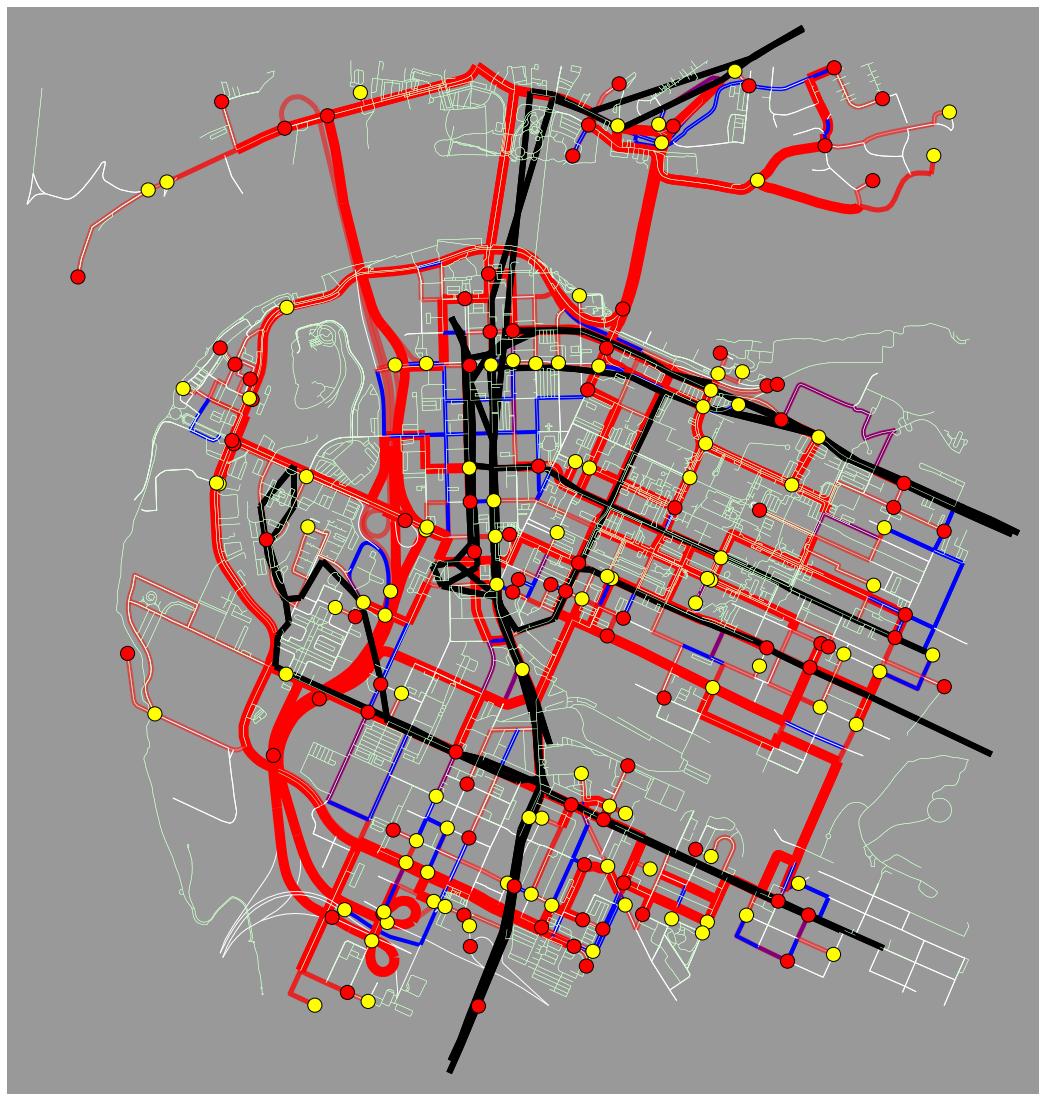

In [29]:
wtshow = {'drive':True,'transit':True,'walk':True,'ondemand':False};
plot_graphs = [];

for _,mode in enumerate(wtshow):
    if wtshow[mode]==True:
        plot_graphs.append(GRAPHS[mode])
full_graph = nx.compose_all(plot_graphs);

def thresh(x,ths):
    m = (ths[3]-ths[1])/(ths[2]-ths[0]);
    b = ths[1]-m*ths[0];
    return np.min([np.max([ths[1],m*x+b]),ths[3]])


def chopoff(x,den,mn,mx): return np.min([np.max([mn,x/den]),mx])

bgcolor = list(0.6*np.array([1,1,1])) + [1]
graph = GRAPHS['drive']        

mx1 = 4;
mwalk = 100;
mdrive = 10;

colors = {'drive':[1,0,0],
          'walk':[1.,1.,0.],
          'transit':[1.,0.5,0.],
          'ondemand':[0.,0.,1.]}
maxwids = {'drive': 10,'walk':10,'transit':10,'ondemand':4}


mxpop1 = num_sources/50;
threshs = {'drive': [0,0,mxpop1,1],
           'walk': [0,0,mxpop1,1],
           'transit': [0,0,mxpop1,1],
           'ondemand': [0,0,1,1]}



node_color = [];
NODE_COLOR = [];
node_size = [];
node_edgecolor = [];
node_zorder = [];
for k,node in enumerate(full_graph.nodes):
    if False:
        print('asdf')
    elif node in source_nodes:
        node_color.append([1,1,0])
        node_size.append(200)        
        node_edgecolor.append('k')   
        node_zorder.append(100);
    elif node in target_nodes:
        node_color.append([1,0,0])
        node_size.append(200)
        node_edgecolor.append('k')
        node_zorder.append(100);
    else: 
        node_color.append([1,1,1]); #[0,0,1])
        node_size.append(0)
        node_edgecolor.append('w')
        node_zorder.append(1);        



                
edge_color = [];
edge_width = [];
drive_edges = list(GRAPHS['drive'].edges())
ondemand_edges = list(GRAPHS['ondemand'].edges())
walk_edges = list(GRAPHS['walk'].edges())
transit_edges = list(GRAPHS['transit'].edges())
for k,edge in enumerate(full_graph.edges()):
#     if edge_found == False: 
#     edge_found = False;
#     if wtshow['drive'] == True:

    if edge in drive_edges:
        edge_found = True;
        tag = (edge[0],edge[1],0)
        edge_mass = WORLD['drive']['current_edge_masses'][tag]
        ondemand_mass = WORLD['ondemand']['current_edge_masses'][tag]
        if edge_mass > 0:
            edge_color.append(colors['drive']+[thresh(edge_mass,threshs['drive'])]); #[chopoff(edge_mass,mx1,0,1)])
            edge_width.append(maxwids['drive']*thresh(edge_mass,threshs['drive']));
            #maxwids['drive']*chopoff(edge_mass,mx1,0.5,1))            
        elif ondemand_mass > 0:
            #print('found ondemand edge...')
            edge_color.append(colors['ondemand']+[thresh(ondemand_mass,threshs['ondemand'])]); #[chopoff(edge_mass,mx1,0,1)])
            edge_width.append(maxwids['ondemand']*thresh(ondemand_mass,threshs['ondemand']));
        else:
            edge_color.append([1,1,1]); 
            edge_width.append(1)
            
#     if wtshow['transit'] == True:
    elif edge in transit_edges:
        edge_found = True;
        tag = (edge[0],edge[1],0)
        edge_mass = WORLD['transit']['current_edge_masses'][tag]
        if edge_mass > 0:
            print('yo...')
            edge_color.append(colors['transit']+[thresh(edge_mass,threshs['transit'])]);
            edge_width.append(maxwids['transit']*thresh(edge_mass,threshs['transit']));
        else: 
            edge_color.append([0,0,0]); #colors['transit']);
            edge_width.append(6)            
    elif edge in walk_edges:
        edge_found = True;
        tag = (edge[0],edge[1],0)
        edge_mass = WORLD['walk']['current_edge_masses'][tag]
        if edge_mass > 0:
            #edge_color.append(winter_cmap(chopoff(edge_mass,mx1,0,1)))
            edge_color.append(colors['walk'] + [thresh(edge_mass,threshs['walk'])]); #[chopoff(edge_mass,mwalk,0,1)])
            #edge_width.append(maxwids['walk']*thresh(edge_mass,threshs['walk'])); #chopoff(edge_mass,mwalk,0.5,1))
            edge_width.append(2); 
        else: 
            edge_color.append([0.8,1,0.8]); 
            edge_width.append(0.5)
                
    else:
        edge_color.append([1,1,1]);
        edge_width.append(0.5)   
        

        
        
# edge_masses = {'drive':[]};
# zmodes = ['drive','transit','walk'];
# edge_masses = {}
# for _,mode in enumerate(zmodes)
#     drive_trip_edges = []; NETWORK = WORLD['drive'];
#     for e,edge in enumerate(NETWORK['current_edge_masses']):  
#     path = DRIVE['trips'][trip]['path'][-1]
#     for j,node in enumerate(path):
#         if j < len(path)-1:
#             edge = (path[j],path[j+1],0);
#         drive_trip_edges.append(edge)
# graph = GRAPHS['drive']                
        
fig, ax = ox.plot_graph(full_graph,bgcolor=bgcolor,
                        node_color=node_color,node_edgecolor=node_edgecolor,
                        node_size=node_size,node_zorder=1,#node_zorder,
                        edge_color=edge_color,
                        edge_linewidth=edge_width,figsize=(20,20)); #file_format='svg')        

In [34]:
print(WORLD['walk']['trips']['costs']); #.keys())


xx = np.linspace(-2,4,100)
yy = [thresh(zz,[1,1,2,2]) for _,zz in enumerate(xx)]
plt.plot(xx,yy)

KeyError: 'costs'

In [35]:
trip = list(WORLD['walk']['trips'].keys())[0]
print(WORLD['walk']['trips'][trip]['costs']); #.keys())

{'time': [13, 13, 13, 13, 13, 13, 13, 13, 13], 'money': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'conven': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'switches': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'current_time': 13, 'current_money': 1, 'current_conven': 1, 'current_switches': 1}


## DRIVE 

In [ ]:
#### EDGES 
bgcolor = [0.8,0.8,0.8,1]
node_color = [];
NODE_COLOR = [];
node_size = [];
node_edgecolor = [];
node_zorder = [];
edge_color = [];
edge_width = [];
drive_trip_edges = [];
for i,trip in enumerate(DRIVE['trips']):
    path = DRIVE['trips'][trip]['path'][-1]
    for j,node in enumerate(path):
        if j < len(path)-1:
            edge = (path[j],path[j+1],0);
        drive_trip_edges.append(edge)
        
graph = GRAPHS['drive']        

for k,node in enumerate(graph.nodes):
    if False:
        print('asdf')
#     elif node == sink:
#         node_color.append([0,0,0]); #[0,0,1])
#         node_size.append(100)
#     elif node in all_pickup_nodes: 
#         ii = np.where([node == n for n in all_pickup_nodes])[0][0];
#         # NODE_COLOR[i][node] = [0,0,1]
#         node_color.append(cmap(Mlocs[ii]/maxMloc))
#         node_size.append(200)
    elif node in node_lists['source']['drive']:
        node_color.append([0,0,1])
        node_size.append(100)        
        node_edgecolor.append('k')   
        node_zorder.append(100);
    elif node in node_lists['target']['drive']:
        node_color.append([1,0,0])
        node_size.append(100)
        node_edgecolor.append('k')
        node_zorder.append(100);        

    elif node in node_lists['transit_drive1']['drive']:
        node_color.append([0,0,1,0.5])
        node_size.append(50)
        node_edgecolor.append('w')
        node_zorder.append(10);        
    elif node in node_lists['transit_drive2']['drive']:
        node_color.append([1,0,0,0.5])
        node_size.append(50)
        node_edgecolor.append('w')
        node_zorder.append(10);        
        
#     elif node in target_nodes:
#         node_color.append([0,0,1])
#         node_size.append(200)        
#     elif node in delivery_nodes:
#         node_color.append([1,0,1])
#         node_size.append(200)        
#     elif node in delivery2_nodes:
#         node_color.append([1,0,0])
#         node_size.append(200)        
        
    else: 
        node_color.append([1,1,1]); #[0,0,1])
        node_size.append(10)
        node_edgecolor.append('w')
        node_zorder.append(1);        
                
for k,edge in enumerate(graph.edges):    
    edge_found = False;
    if edge_found == False:
        if edge in drive_trip_edges:
            edge_color.append([0,0,0]); 
            edge_width.append(4)             
        else: 
            edge_color.append([1,1,1]);
            edge_width.append(2)             
        
                    
fig, ax = ox.plot_graph(GRAPHS['drive'],bgcolor=bgcolor,
                        node_color=node_color,node_edgecolor=node_edgecolor,
                        node_size=node_size,node_zorder=1,#node_zorder,
                        edge_color=edge_color, edge_linewidth=edge_width)

## ONDEMAND 

In [ ]:
#### EDGES         

bgcolor = [0.8,0.8,0.8,1]
node_color = [];
NODE_COLOR = [];
node_size = [];
edge_color = [];
node_edgecolor = [];
edge_width = [];
ondemand_trip_edges = [];
for i,trip in enumerate(ONDEMAND['trips']):
    path = ONDEMAND['trips'][trip]['tsp']['route']; #path'][-1]
    for j,node in enumerate(path):
        if j < len(path)-1:
            edge = (path[j],path[j+1],0);
        ondemand_trip_edges.append(edge)       
        
graph = GRAPHS['ondemand']
for k,node in enumerate(graph.nodes):

    if False: 
        print('asdf')
#     if node == sink:        
#         node_color.append([0,0,0]); #[0,0,1])
#         node_size.append(400)
#     elif node in all_pickup_nodes: 
#         ii = np.where([node == n for n in all_pickup_nodes])[0][0];
#         # NODE_COLOR[i][node] = [0,0,1]
#         node_color.append(cmap(Mlocs[ii]/maxMloc))
#         node_size.append(200)

    elif node in node_lists['source']['ondemand']:
        node_color.append([0,0,1])
        node_size.append(100)
        node_edgecolor.append('k')
    elif node in node_lists['target']['ondemand']:
        node_color.append([1,0,0])
        node_size.append(100)
        node_edgecolor.append('k')        
    elif node in node_lists['transit_ondemand1']['ondemand']:
        node_color.append([1,0,1])
        node_size.append(50)
        node_edgecolor.append('w')        
    elif node in node_lists['transit_ondemand2']['ondemand']:
        node_color.append([1,0,1])
        node_size.append(50)        
        node_edgecolor.append('w')
        
    elif node in delivery1_node_lists['source']:
        node_color.append([0,0,1])
        node_size.append(100)        
        node_edgecolor.append('k')        
    elif node in delivery2_node_lists['source']:
        node_color.append([0,0,1])
        node_size.append(100)        
        node_edgecolor.append('k')        

    elif node in delivery1_node_lists['transit']:
        node_color.append([1,0.5,0])
        node_size.append(100)        
        node_edgecolor.append('w')        
    elif node in delivery2_node_lists['transit']:
        node_color.append([1,0.5,0])
        node_size.append(100)        
        node_edgecolor.append('w')        
        
    else: 
        node_color.append([1,1,1]); #[0,0,1])
        node_size.append(2)
        node_edgecolor.append('w')        
        
                
for k,edge in enumerate(graph.edges):    
    edge_found = False;
    if edge_found == False:
        if False: #edge in drive_trip_edges:
            edge_color.append([0,0,0]); 
            edge_width.append(4)             
        elif edge in ondemand_trip_edges:
            edge_color.append([0,0,0]); 
            edge_width.append(4)                         
        else: 
            edge_color.append([1,1,1]);
            edge_width.append(2)             
        
                    
fig, ax = ox.plot_graph(GRAPHS['ondemand'],bgcolor=bgcolor,
                        node_color=node_color,
                        node_edgecolor=node_edgecolor,node_size=node_size,node_zorder=1,
                        edge_color=edge_color, edge_linewidth=edge_width)

## TRANSIT 

In [ ]:
bgcolor = [0.8,0.8,0.8]
node_color = [];
NODE_COLOR = [];
node_size = [];
edge_color = [];
edge_width = [];

# walk_transit_nodes = [];
# for i,person in enumerate(PEOPLE):
#     walk_transit_nodes.append(PERSON['sources']['walk_final']);
#     walk_transit_nodes.append(PERSON['targets']['walk_initial']);

transit_trip_edges = [];        
for i,trip in enumerate(TRANSIT['trips']):
    path = TRANSIT['trips'][trip]['path'][-1]
    if (len(path)>1) and (len(path) < 50):
        #print(TRANSIT['trips'][trip]['path'][0])
        for j,node in enumerate(path):
            if j < len(path)-1:
                edge = (path[j],path[j+1],0);
                transit_trip_edges.append(edge)                
                edge = (path[j+1],path[j],0);
                transit_trip_edges.append(edge)           
                
for k,node in enumerate(GRAPHS['transit'].nodes):
    if False: #node in delivery_transit_nodes:
        node_color.append([0,1,0])
        node_size.append(50)
        
    elif node in node_lists['transit_walk1']['transit']:
        node_color.append([1,0.75,0])
        node_size.append(50)        
    elif node in node_lists['transit_walk2']['transit']:
        node_color.append([1,0.5,0])
        node_size.append(50)        
    elif node in node_lists['transit_ondemand1']['transit']:
        node_color.append([1,0,0.75])
        node_size.append(50)        
    elif node in node_lists['transit_ondemand2']['transit']:
        node_color.append([1,0,0.5])
        node_size.append(50)        
        
        
    else: 
        node_color.append([1,1,1]); #[0,0,1])
        node_size.append(2)                
            

for k,edge in enumerate(GRAPHS['transit'].edges):    
    edge_found = False;
    if edge_found == False:
        if edge in transit_trip_edges:
            edge_color.append([0,0,0]); 
            edge_width.append(4)             
        else: 
            edge_color.append([1,1,1]);
            edge_width.append(2)         
            
            
            

fig, ax = ox.plot_graph(GRAPHS['transit'],bgcolor=bgcolor,
                        node_color=node_color,node_edgecolor='w',node_size=node_size,node_zorder=1,
                        edge_color=edge_color, edge_linewidth=edge_width)

fileName = 'current'
printFigs = True;
plt.axis('off')
if printFigs:
    plt.savefig(fileName+'.pdf',bbox_inches='tight',pad_inches = 0,transparent=True)

        
                    

In [ ]:
print(delivery_transit_nodes[0] in GRAPHS['transit'].nodes)
print(walk_transit_nodes)

## WALK 

In [ ]:
draw_source_nodes = [];
draw_target_nodes = [];
draw_transit_nodes = [];

bgcolor = [0.8,0.8,0.8]
node_color = [];
NODE_COLOR = [];
node_size = [];
edge_color = [];
edge_width = [];

walk_initial_edges = [];
walk_final_edges = [];
walk_trip_edges = [];

for i,trip in enumerate(WALK['trips']):
    path = WALK['trips'][trip]['path'][-1]
    for j,node in enumerate(path):
        if j < len(path)-1:
            edge = (path[j],path[j+1],0);
        walk_trip_edges.append(edge)


graph = GRAPHS['walk']
# print(graph.nodes)

# for i,person in enumerate(PEOPLE):
#     draw_source_nodes.append(PERSON['sources']['walk_initial']);
#     draw_transit_nodes.append(PERSON['sources']['walk_final']);
#     draw_transit_nodes.append(PERSON['targets']['walk_initial']);
#     draw_target_nodes.append(PERSON['targets']['walk_final']);
    
# for p,person in enumerate(PEOPLE):
#     PERSON = PEOPLE[person]
#     node1 = PERSON['sources']['walk_initial'];
#     node2 = PERSON['targets']['walk_initial'];
#     trip = (node1,node2);
#     path = WALK['trips'][trip]['path'][-1]
#     for j,node in enumerate(path):
#         if j < len(path)-1:
#             edge = (path[j],path[j+1],0);
#             walk_initial_edges.append(edge);                           
#             edge = (path[j+1],path[j],0);
#             walk_initial_edges.append(edge);
#     node1 = PERSON['sources']['walk_final'];
#     node2 = PERSON['targets']['walk_final'];
#     trip = (node1,node2);
#     path = WALK['trips'][trip]['path'][-1]
#     for j,node in enumerate(path):
#         if j < len(path)-1:
#             edge = (path[j],path[j+1],0);
#             walk_final_edges.append(edge)                            
#             edge = (path[j+1],path[j],0);
#             walk_final_edges.append(edge)
            
   
for k,node in enumerate(graph.nodes):
    if False: #node in draw_source_nodes:
        node_color.append([0,0,0])
        node_size.append(200)
    elif node in node_lists['source']['walk']:
        node_color.append([0,0,1])
        node_size.append(50)        
    elif node in node_lists['target']['walk']:
        node_color.append([1,0,0])
        node_size.append(50)        
    elif node in node_lists['transit_walk1']['walk']:
        node_color.append([1,.8,0])
        node_size.append(50)        
    elif node in node_lists['transit_walk2']['walk']:
        node_color.append([1,0.5,0])
        node_size.append(50)        
        
#     elif node in walk_transit_final_nodes:

#         node_color.append([1,0,0])
#         node_size.append(200)        
    else: 
        node_color.append([1,1,1]); #[0,0,1])
        node_size.append(1)    
    

for k,edge in enumerate(GRAPHS['walk'].edges):
    edge_found = False;
    if edge_found == False:
        if False: #edge in walk_initial_edges:
            edge_color.append([1,0,0]); 
            edge_width.append(4)
        elif edge in walk_final_edges:
            edge_color.append([0,0,1]); 
            edge_width.append(4)
        elif edge in walk_trip_edges:
            edge_color.append([0,0,0]); 
            edge_width.append(4)
        else: 
            edge_color.append([1,1,1]);
            edge_width.append(1)

fig, ax = ox.plot_graph(GRAPHS['walk'],bgcolor=bgcolor,
                        node_color=node_color,node_edgecolor='w',node_size=node_size,node_zorder=1,
                        edge_color=edge_color, edge_linewidth=edge_width)

In [ ]:

cutoff = VARS['lam'][-1];
for k, node in enumerate(all_pickup_nodes):
    if node in VARS['pickups'][ind]:
        ii = np.where([node==n for _,n in enumerate(all_pickup_nodes)])[0][0];
        if Mlocs[ii]>cutoff:
            print('check')
        
        else:
            print('error: ', Mlocs[ii]-cutoff);

In [ ]:
print(VARS['lam'][ind])
Mlocs1 = [];

nbins = 20;
bin_width = (np.max(Mlocs)-np.min(Mlocs))/nbins;
bins = np.min(Mlocs) + bin_width*np.array(list(range(nbins+1)))
for i,node in enumerate(NODES):
    Mlocs1.append(MLOCS[node])
ax = plt.hist(Mlocs,bins,color='blue')
ax = plt.hist(Mlocs1,bins, color = 'orange',alpha=1.)
plt.xlim([0,1000])

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

# get graphs of different infrastructure types, then combine
place = 'Berkeley, California, USA'
G1 = ox.graph_from_place(place, custom_filter='["highway"~"residential"]')
G2 = ox.graph_from_place(place, custom_filter='["railway"~"rail"]')
G = nx.compose(G1, G2)

# get building footprints
fp = ox.footprints_from_place(place)

# plot highway edges in yellow, railway edges in red
ec = ['y' if 'highway' in d else 'r' for _, _, _, d in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, bgcolor='k', edge_color=ec,
                        node_size=0, edge_linewidth=0.5,
                        show=False, close=False)

# add building footprints in 50% opacity white
fp.plot(ax=ax, color='w', alpha=0.5)
plt.show()